In [1]:
from htm.bindings.sdr import SDR
from htm.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
import numpy as np
import pandas as pd
import pathlib
import datetime
import csv
from datetime import datetime
import os
from htm.encoders.rdse import RDSE, RDSE_Parameters
import time
import traceback
from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [2]:
inputSources = [
   "monthly_sp500_pca.csv",
   "weekly_dow_jones.csv",
   "weekly_nasdaq.csv",
   "weekly_sp500.csv",
   "monthly_vix_close.csv",
   "monthly_vix_high.csv",
   "monthly_vix_low.csv",
   "monthly_vix_open.csv",
   "daily_natural_gas.csv",
   "daily_oil_prices.csv",
   "value1_vix_close.csv",
   "value1_vix_high.csv",
   "value1_vix_low.csv",
   "value1_vix_open.csv",
   "monthly_gold_prices.csv"
]

In [3]:

config = {
    'enc': {
        "value" :
            {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
        "time": 
            {'timeOfDay': (30, 1), 'weekend': 21}
    },
    'sp': {
        'inputDimensions': None,
        'columnDimensions': (1638,),
        'potentialPct': 0.85,
        'potentialRadius': None,
        'globalInhibition': True,
        'localAreaDensity': 0.04395604395604396,
        'synPermInactiveDec': 0.006,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'boostStrength': 3.0,
        'wrapAround': True,
        'seed': 1,
        'learn': False,
    },
    'tm': {
        'cellsPerColumn': 13,
        'activationThreshold': 17,
        'initialPermanence': 0.21,
        'minThreshold': 10,
        'maxNewSynapseCount': 32,
        'permanenceIncrement': 0.1,
        'permanenceDecrement': 0.1,
        'predictedSegmentDecrement': 0.0,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'learn': True
    },
    'anomaly': {'period': 1000},
    'learnRows': 100,
    'reflexSize': 2048,
    'accuracyThreshold': 0.5,
    'controlThreshold': 4
}


In [4]:
class ReflexiveMemory:
  def __init__(self, reflexSize, dimensions_dense, dimensions_sparse_sp):
    self.acKey0 = None
    self.pairs = {}
    self.tableSize  = reflexSize
    self.dimensions_dense = dimensions_dense
    self.dimensions_sparse_sp = dimensions_sparse_sp

  def add(self, denseColumns):
    acKey1 = '-'.join(map(str, denseColumns.sparse))
    if(self.acKey0 != None):

      sequence = self.pairs.get(self.acKey0, {})
      sequence_data = sequence.get(acKey1, {
         "count": 0,
         "time": datetime.now()
      })
      if sequence_data["count"] < 256:
        sequence_data["count"] = sequence_data["count"] + 1
      sequence_data["time"] = datetime.now()

      if self.pairs.get(self.acKey0, None) is None:
        self.pairs[self.acKey0] = { acKey1: sequence_data }
      else:
        self.pairs[self.acKey0][acKey1] = sequence_data
        
      table_entries = 0
      oldKey1 = None
      oldKey2 = None
      oldTime = datetime.now()
      for key1, value1 in self.pairs.items():
        table_entries = table_entries + len(value1.items())
        for key2, value2 in value1.items():
          if value2['time'] < oldTime:
            oldKey1 = key1
            oldKey2 = key2
            oldTime = value2['time']
      if table_entries > self.tableSize:
        del self.pairs[oldKey1][oldKey2]
        if len(self.pairs[oldKey1].items()) == 0:
          del self.pairs[oldKey1]

    self.acKey0 = acKey1

  def predict(self, denseColumns):
    return_count = 0
    return_sdr = None

    acKey = '-'.join(map(str, denseColumns.sparse))
    sequences = self.pairs.get(acKey, {})
    for sequence_key, sequence_data in sequences.items():
      if sequence_data["count"] > return_count:
        return_count = sequence_data["count"]
        return_sdr = sequence_key

    if return_sdr is not None:
      tmp_sdr = SDR( self.dimensions_dense )
      tmp_sdr.sparse = list(map(int, return_sdr.split('-')))
      return_sdr = tmp_sdr
    else:
      return_count = None

    return return_count, return_sdr


In [5]:
class ControlHistory:
  def __init__(self):
    self.anomalyRM = []
    self.anomalyTM = []
    self.anomalyNU = []
    self.historyRM = []
    self.historyTM = []
    self.historyGT = []

  def anomalyScore(self, y, x):
      if np.count_nonzero(y) != 0:
          return 1 - np.count_nonzero((x & y)) / np.count_nonzero(y)
      return 1

  def add(self, denseColumns1, sp, tm, rm):

    if rm.acKey0 is not None:

      denseColumns0 = SDR( rm.dimensions_dense )
      denseColumns0.sparse = list(map(int, rm.acKey0.split('-')))

      tm.activateDendrites(True)
      predictiveCells = tm.getPredictiveCells()

      predictiveColumns = SDR( rm.dimensions_sparse_sp )
      predictiveColumns.sparse = list(set(sorted(list(np.where(predictiveCells.dense == 1)[0]))))

      reflexiveColumns = SDR( rm.dimensions_sparse_sp )
      reflexiveCount, denseReflexiveColumns = rm.predict(denseColumns0)
      if denseReflexiveColumns is not None:
        sp.compute(denseReflexiveColumns, False, reflexiveColumns)

      activeColumns0 = SDR( rm.dimensions_sparse_sp )
      sp.compute(denseColumns0, False, activeColumns0)

      activeColumns1 = SDR( rm.dimensions_sparse_sp )
      sp.compute(denseColumns1, False, activeColumns1)

      self.historyRM.append( reflexiveColumns.dense )
      self.historyTM.append( predictiveColumns.dense )
      self.historyGT.append( activeColumns1.dense )

      self.anomalyNU.append(tm.anomaly)
      self.anomalyRM.append( self.anomalyScore(activeColumns1.dense, reflexiveColumns.dense) )
      self.anomalyTM.append( self.anomalyScore(activeColumns1.dense, predictiveColumns.dense) )


In [6]:
class ControlUnit:
  def __init__(self, controlThreshold):
    self.anomalyCU = []
    self.historyCU = []
    self.countRMCU = 0
    self.controlThreshold = controlThreshold

  def compute(self, ch, rm):

    if rm.acKey0 is not None:

      rmin = -1-self.controlThreshold
      if (len(ch.anomalyRM) > self.controlThreshold) and (sum(ch.anomalyRM[rmin:-1]) > sum(ch.anomalyTM[rmin:-1])):
        self.anomalyCU.append( ch.anomalyTM[-1] )
        self.historyCU.append( ch.historyTM[-1] )
        self.countRMCU = self.countRMCU + 1
      else:
        self.anomalyCU.append( ch.anomalyRM[-1] )
        self.historyCU.append( ch.historyRM[-1] )


In [7]:
input_path = pathlib.Path('../datasets/numenta')
dataset_metrics = []

pbar = tqdm(total=len(inputSources))
for dataset in inputSources:

    tm_infer_tm = 0
    tm_infer_rm = 0

    records = []
    with open(input_path.joinpath(dataset), "r") as fin:
        reader = csv.reader(fin)
        headers = next(reader)
        next(reader)
        next(reader)
        for record in reader:
            records.append(record)
        
    scalarEncoderParams = RDSE_Parameters()
    scalarEncoderParams.size = config["enc"]["value"]["size"]
    scalarEncoderParams.sparsity = config["enc"]["value"]["sparsity"]
    scalarEncoderParams.resolution = config["enc"]["value"]["resolution"]
    scalarEncoder = RDSE( scalarEncoderParams )
    encodingWidth = (scalarEncoder.size)

    config['sp']['inputDimensions'] = (encodingWidth,)
    config['sp']['potentialRadius'] = encodingWidth

    sp = SpatialPooler(
        inputDimensions = config['sp']['inputDimensions'],
        columnDimensions = config['sp']['columnDimensions'],
        potentialPct = config['sp']['potentialPct'],
        potentialRadius = config['sp']['potentialRadius'],
        globalInhibition = config['sp']['globalInhibition'],
        localAreaDensity = config['sp']['localAreaDensity'],
        synPermInactiveDec = config['sp']['synPermInactiveDec'],
        synPermActiveInc = config['sp']['synPermActiveInc'],
        synPermConnected = config['sp']['synPermConnected'],
        boostStrength = config['sp']['boostStrength'],
        wrapAround = config['sp']['wrapAround'],
        seed = config['sp']['seed']
    )

    tm = TemporalMemory(
        columnDimensions = config['sp']['columnDimensions'],
        cellsPerColumn = config['tm']['cellsPerColumn'],
        activationThreshold = config['tm']['activationThreshold'],
        initialPermanence = config['tm']['initialPermanence'],
        connectedPermanence = config['sp']['synPermConnected'],
        minThreshold = config['tm']['minThreshold'],
        maxNewSynapseCount = config['tm']['maxNewSynapseCount'],
        permanenceIncrement = config['tm']['permanenceIncrement'],
        permanenceDecrement = config['tm']['permanenceDecrement'],
        predictedSegmentDecrement = config['tm']['predictedSegmentDecrement'],
        maxSegmentsPerCell = config['tm']['maxSegmentsPerCell'],
        maxSynapsesPerSegment = config['tm']['maxSynapsesPerSegment']
    )

    rm = ReflexiveMemory( config['reflexSize'] , config['sp']['inputDimensions'], config['sp']['columnDimensions'])

    ch = ControlHistory()
    cu01 = ControlUnit( 1 )
    cu02 = ControlUnit( 2 )
    cu04 = ControlUnit( 4 )
    cu08 = ControlUnit( 8 )
    cu16 = ControlUnit( 16 )
    cu32 = ControlUnit( 32 )
    cu64 = ControlUnit( 64 )


    try:
        
        for count, record in enumerate(records):
            
            learn_sp = config['sp']['learn']
            learn_tm = config['tm']['learn']
            if count < config['learnRows']:
                learn_sp = True
                learn_tm = True

            consumption = float(record[1])
            consumptionBits = scalarEncoder.encode(consumption)
            encoding = SDR( consumptionBits )

            ch.add(encoding, sp, tm, rm)
            cu01.compute(ch, rm)
            cu02.compute(ch, rm)
            cu04.compute(ch, rm)
            cu08.compute(ch, rm)
            cu16.compute(ch, rm)
            cu32.compute(ch, rm)
            cu64.compute(ch, rm)


            tmp_tm = time.time()
            rm.add(encoding)
            rm.predict(encoding)
            tm_infer_rm = tm_infer_rm + (time.time() - tmp_tm)

            activeColumns = SDR( sp.getColumnDimensions() )

            tmp_tm = time.time()
            sp.compute(encoding, learn_sp, activeColumns)
            tm.compute(activeColumns, learn=learn_tm)
            tm_infer_tm = tm_infer_tm + (time.time() - tmp_tm)

    except Exception as e:
        print(traceback.format_exc())
        print(e)

    def match(y, x, idx1, ch, accuracyThreshold):
        n_samples = len(y)
        score1 = ch.anomalyScore(y[idx1], x[idx1])
        if score1 > (1 - accuracyThreshold):
            idx_closest = None
            score_closest = None
            for idx2 in range(n_samples):
                score2 = ch.anomalyScore(y[idx2], x[idx1])
                if score_closest is None or score_closest > score2:
                    score_closest = score2
                    idx_closest = idx2
            return idx_closest
        return idx1

    def calculateMetrics(config, cu, ch, tm_infer_rm, tm_infer_tm, suffix):

        metric = {}

        n_samples = len(ch.historyGT)

        Y_labels = list(range(n_samples))
        X_labels = [ match(ch.historyGT, cu.historyCU, idx, ch, config['accuracyThreshold']) for idx in range(n_samples)]

        total_infe_time = 0
        avg_infer_time_rm = tm_infer_rm / len(ch.anomalyRM)
        avg_infer_time_tm = tm_infer_tm / len(ch.anomalyTM)
        total_infe_time = total_infe_time + (avg_infer_time_rm * cu.countRMCU)
        total_infe_time = total_infe_time + (avg_infer_time_tm * (len(cu.anomalyCU) - cu.countRMCU))

        metric['rm-count-'+suffix] = cu.countRMCU
        metric['anomaly-samples-'+suffix] = len(cu.historyCU)
        metric['tm-count-'+suffix] = len(cu.historyCU) - cu.countRMCU

        metric['total-infer-time-'+suffix] = total_infe_time
        metric['infer-time-'+suffix] = total_infe_time / len(cu.anomalyCU)
        metric['accuracy-'+suffix] = accuracy_score(Y_labels, X_labels)

        X_labels = [ match(ch.historyGT, ch.historyTM, idx, ch, config['accuracyThreshold']) for idx in range(n_samples)]
        metric['accuracy-improvement-'+suffix] = metric['accuracy-'+suffix] - accuracy_score(Y_labels, X_labels)
        metric['infer-speedup-'+suffix] = 1 - (total_infe_time / tm_infer_tm)

        return metric

    metric = {}
    metric['dataset'] = dataset
    metric.update( calculateMetrics(config, cu01, ch, tm_infer_rm, tm_infer_tm, 'cu01') )
    metric.update( calculateMetrics(config, cu02, ch, tm_infer_rm, tm_infer_tm, 'cu02') )
    metric.update( calculateMetrics(config, cu04, ch, tm_infer_rm, tm_infer_tm, 'cu04') )
    metric.update( calculateMetrics(config, cu08, ch, tm_infer_rm, tm_infer_tm, 'cu08') )
    metric.update( calculateMetrics(config, cu16, ch, tm_infer_rm, tm_infer_tm, 'cu16') )
    metric.update( calculateMetrics(config, cu32, ch, tm_infer_rm, tm_infer_tm, 'cu32') )
    metric.update( calculateMetrics(config, cu64, ch, tm_infer_rm, tm_infer_tm, 'cu64') )

    dataset_metrics.append(metric)
    pbar.update(1)
    # break

pbar.close()

100%|██████████| 15/15 [07:03<00:00, 28.23s/it]


In [8]:
df = pd.DataFrame(dataset_metrics)
df.to_csv('metrics.csv', index=False)

In [9]:
table_1_features = ['dataset'] + [v for v in df.columns if 'accuracy-cu' in v]
df[table_1_features]

,dataset,accuracy-cu01,accuracy-cu02,accuracy-cu04,accuracy-cu08,accuracy-cu16,accuracy-cu32,accuracy-cu64
0,monthly_sp500_pca.csv,0.361974,0.381475,0.398537,0.402803,0.402803,0.404022,0.401584
1,weekly_dow_jones.csv,0.024050,0.029822,0.032708,0.033670,0.033670,0.033189,0.032708
2,weekly_nasdaq.csv,0.191346,0.204808,0.211538,0.212500,0.212500,0.212500,0.204808
3,weekly_sp500.csv,0.324844,0.348871,0.353676,0.354157,0.353676,0.353196,0.348871
4,monthly_vix_close.csv,0.881235,0.933580,0.958025,0.963951,0.964444,0.964198,0.963704
5,monthly_vix_high.csv,0.871605,0.918765,0.941235,0.945926,0.946667,0.946667,0.946667
6,monthly_vix_low.csv,0.911605,0.954815,0.975556,0.979753,0.978765,0.979506,0.979506
7,monthly_vix_open.csv,0.871358,0.922716,0.946173,0.952346,0.952840,0.952346,0.951852
8,daily_natural_gas.csv,0.979476,0.981890,0.986375,0.988962,0.991549,0.994481,0.995861
9,daily_oil_prices.csv,0.977229,0.985783,0.990361,0.993494,0.994458,0.994699,0.994458


In [10]:
table_2_features = ['dataset'] + [v for v in df.columns if 'total-infer-time' in v]
df[table_2_features]

,dataset,total-infer-time-cu01,total-infer-time-cu02,total-infer-time-cu04,total-infer-time-cu08,total-infer-time-cu16,total-infer-time-cu32,total-infer-time-cu64
0,monthly_sp500_pca.csv,0.234416,0.176965,0.128742,0.105822,0.101654,0.103440,0.109691
1,weekly_dow_jones.csv,0.510701,0.424528,0.346381,0.283581,0.228807,0.207795,0.214642
2,weekly_nasdaq.csv,0.403881,0.304016,0.237920,0.206460,0.196069,0.193183,0.202130
3,weekly_sp500.csv,0.286208,0.211021,0.175154,0.163464,0.162136,0.164527,0.173029
4,monthly_vix_close.csv,0.507247,0.295768,0.169876,0.132187,0.129569,0.130354,0.131663
5,monthly_vix_high.csv,0.540963,0.315081,0.181942,0.140976,0.132157,0.133295,0.136993
6,monthly_vix_low.csv,0.370194,0.236839,0.152237,0.120213,0.116229,0.115433,0.117185
7,monthly_vix_open.csv,0.572488,0.333581,0.192656,0.140036,0.132778,0.131870,0.136709
8,daily_natural_gas.csv,0.318916,0.295538,0.262791,0.224570,0.185653,0.149891,0.120252
9,daily_oil_prices.csv,0.556265,0.439755,0.349401,0.295332,0.270052,0.264789,0.266703


In [11]:
table_3_features = ['dataset'] + [v for v in df.columns if 'infer-time' in v and 'total' not in v]
df[table_3_features]

,dataset,infer-time-cu01,infer-time-cu02,infer-time-cu04,infer-time-cu08,infer-time-cu16,infer-time-cu32,infer-time-cu64
0,monthly_sp500_pca.csv,0.000143,0.000108,0.000078,0.000064,0.000062,0.000063,0.000067
1,weekly_dow_jones.csv,0.000246,0.000204,0.000167,0.000136,0.000110,0.000100,0.000103
2,weekly_nasdaq.csv,0.000194,0.000146,0.000114,0.000099,0.000094,0.000093,0.000097
3,weekly_sp500.csv,0.000138,0.000101,0.000084,0.000079,0.000078,0.000079,0.000083
4,monthly_vix_close.csv,0.000125,0.000073,0.000042,0.000033,0.000032,0.000032,0.000033
5,monthly_vix_high.csv,0.000134,0.000078,0.000045,0.000035,0.000033,0.000033,0.000034
6,monthly_vix_low.csv,0.000091,0.000058,0.000038,0.000030,0.000029,0.000029,0.000029
7,monthly_vix_open.csv,0.000141,0.000082,0.000048,0.000035,0.000033,0.000033,0.000034
8,daily_natural_gas.csv,0.000055,0.000051,0.000045,0.000039,0.000032,0.000026,0.000021
9,daily_oil_prices.csv,0.000067,0.000053,0.000042,0.000036,0.000033,0.000032,0.000032


In [12]:
table_4_features = ['dataset'] + [v for v in df.columns if 'accuracy-improvement' in v]
df[table_4_features]

,dataset,accuracy-improvement-cu01,accuracy-improvement-cu02,accuracy-improvement-cu04,accuracy-improvement-cu08,accuracy-improvement-cu16,accuracy-improvement-cu32,accuracy-improvement-cu64
0,monthly_sp500_pca.csv,-0.041438,-0.021938,-0.004875,-0.000609,-0.000609,0.000609,-0.001828
1,weekly_dow_jones.csv,-0.009620,-0.003848,-0.000962,0.000000,0.000000,-0.000481,-0.000962
2,weekly_nasdaq.csv,-0.022596,-0.009135,-0.002404,-0.001442,-0.001442,-0.001442,-0.009135
3,weekly_sp500.csv,-0.029313,-0.005286,-0.000481,0.000000,-0.000481,-0.000961,-0.005286
4,monthly_vix_close.csv,-0.083457,-0.031111,-0.006667,-0.000741,-0.000247,-0.000494,-0.000988
5,monthly_vix_high.csv,-0.075802,-0.028642,-0.006173,-0.001481,-0.000741,-0.000741,-0.000741
6,monthly_vix_low.csv,-0.068889,-0.025679,-0.004938,-0.000741,-0.001728,-0.000988,-0.000988
7,monthly_vix_open.csv,-0.079753,-0.028395,-0.004938,0.001235,0.001728,0.001235,0.000741
8,daily_natural_gas.csv,-0.016212,-0.013798,-0.009314,-0.006726,-0.004139,-0.001207,0.000172
9,daily_oil_prices.csv,-0.016747,-0.008193,-0.003614,-0.000482,0.000482,0.000723,0.000482


In [13]:
table_5_features = ['dataset'] + [v for v in df.columns if 'infer-speedup' in v]
df[table_5_features]

,dataset,infer-speedup-cu01,infer-speedup-cu02,infer-speedup-cu04,infer-speedup-cu08,infer-speedup-cu16,infer-speedup-cu32,infer-speedup-cu64
0,monthly_sp500_pca.csv,0.595221,0.694424,0.777693,0.817272,0.824468,0.821384,0.810590
1,weekly_dow_jones.csv,0.260247,0.385070,0.498265,0.589232,0.668572,0.699008,0.689090
2,weekly_nasdaq.csv,0.484849,0.612227,0.696533,0.736660,0.749914,0.753595,0.742183
3,weekly_sp500.csv,0.596266,0.702327,0.752921,0.769412,0.771285,0.767912,0.755920
4,monthly_vix_close.csv,0.567501,0.747816,0.855157,0.887293,0.889524,0.888855,0.887739
5,monthly_vix_high.csv,0.574174,0.751980,0.856782,0.889029,0.895971,0.895076,0.892164
6,monthly_vix_low.csv,0.506739,0.684427,0.797153,0.839824,0.845131,0.846193,0.843858
7,monthly_vix_open.csv,0.572871,0.751118,0.856261,0.895521,0.900936,0.901613,0.898003
8,daily_natural_gas.csv,0.104228,0.169891,0.261872,0.369227,0.478536,0.578985,0.662237
9,daily_oil_prices.csv,0.395411,0.522043,0.620246,0.679012,0.706488,0.712208,0.710128


In [14]:
table_6_features = ['dataset'] + sorted(list(set(df.columns) - (set(table_1_features) | set(table_2_features) | set(table_3_features) | set(table_4_features) | set(table_5_features))))
df[table_6_features]

,dataset,anomaly-samples-cu01,anomaly-samples-cu02,anomaly-samples-cu04,anomaly-samples-cu08,anomaly-samples-cu16,anomaly-samples-cu32,anomaly-samples-cu64,rm-count-cu01,rm-count-cu02,...,rm-count-cu16,rm-count-cu32,rm-count-cu64,tm-count-cu01,tm-count-cu02,tm-count-cu04,tm-count-cu08,tm-count-cu16,tm-count-cu32,tm-count-cu64
0,monthly_sp500_pca.csv,1641,1641,1641,1641,1641,1641,1641,1158,1351,...,1604,1598,1577,483,290,128,51,37,43,64
1,weekly_dow_jones.csv,2079,2079,2079,2079,2079,2079,2079,761,1126,...,1955,2044,2015,1318,953,622,356,124,35,64
2,weekly_nasdaq.csv,2080,2080,2080,2080,2080,2080,2080,1317,1663,...,2037,2047,2016,763,417,188,79,43,33,64
3,weekly_sp500.csv,2081,2081,2081,2081,2081,2081,2081,1591,1874,...,2058,2049,2017,490,207,72,28,23,32,64
4,monthly_vix_close.csv,4050,4050,4050,4050,4050,4050,4050,2543,3351,...,3986,3983,3978,1507,699,218,74,64,67,72
5,monthly_vix_high.csv,4050,4050,4050,4050,4050,4050,4050,2564,3358,...,4001,3997,3984,1486,692,224,80,49,53,66
6,monthly_vix_low.csv,4050,4050,4050,4050,4050,4050,4050,2387,3224,...,3981,3986,3975,1663,826,295,94,69,64,75
7,monthly_vix_open.csv,4050,4050,4050,4050,4050,4050,4050,2539,3329,...,3993,3996,3980,1511,721,255,81,57,54,70
8,daily_natural_gas.csv,5798,5798,5798,5798,5798,5798,5798,800,1304,...,3673,4444,5083,4998,4494,3788,2964,2125,1354,715
9,daily_oil_prices.csv,8300,8300,8300,8300,8300,8300,8300,4562,6023,...,8151,8217,8193,3738,2277,1144,466,149,83,107


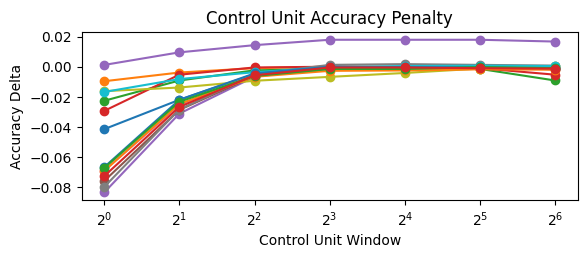

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(2,1,2)
plt.title("Control Unit Accuracy Penalty")
plt.xlabel("Control Unit Window")
plt.ylabel("Accuracy Delta")
plt.xscale('log',base=2) 

columns = [v for v in df.columns if 'accuracy-improvement-cu' in v]
for row in df[columns].values:
    plt.plot([int(v.lstrip('accuracy-improvement-cu')) for v in columns], row, label='Line 1', marker='o')

# plt.legend(labels=df['dataset'].values)
plt.show()

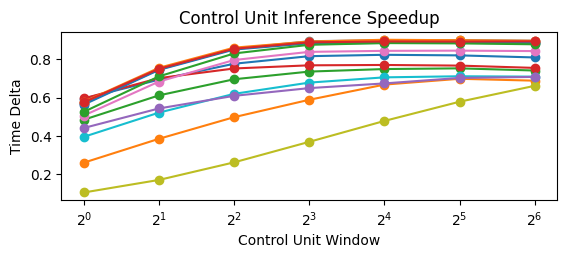

In [24]:
import matplotlib.pyplot as plt

plt.subplot(2,1,2)
plt.title("Control Unit Inference Speedup")
plt.xlabel("Control Unit Window")
plt.ylabel("Time Delta")
plt.xscale('log',base=2) 

columns = [v for v in df.columns if 'infer-speedup-cu' in v]
for row in df[columns].values:
    plt.plot([int(v.lstrip('infer-speedup-cu')) for v in columns], row, marker='o')

# plt.legend(labels=df['dataset'].values)
plt.show()